In [1]:
import pandas as pd
import numpy as np 
from datetime import datetime
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# GDP_NOM_SECTORS: Nominal GDP of different sectors
# GDP_YOY_SECTORS: Year-on-year real GDP growth rates for different sectors
# AR: Agriculture, Forestry and Fisheries
# ID: Industrial
# CO: Construction
# WH: Wholesale and retail trade
# TR: Transportation, storage and postal services
# AC: Accommodation and catering
# FI: Finance
# RE: Real Estate
# IN: Information transmission, software and information technology services
# LE: Leasing and business services
# OT: Other Industries

In [2]:
GDP_NOM_SECTORS = pd.read_csv('GDP_NOM_SECTORS.csv').set_index('QTR')
GDP_YOY_SECTORS = pd.read_csv('GDP_YOY_SECTORS.csv').set_index('QTR')
GDP_YOY = pd.read_csv('GDP_YOY.csv').set_index('QTR')
GDP_YOY_SECTORS['OT'] = (GDP_NOM_SECTORS[['IN', 'LE', 'OT']].sum(axis = 1) / np.multiply(GDP_NOM_SECTORS[['IN', 'LE', 'OT']] , 1 / (1 + GDP_YOY_SECTORS[['IN', 'LE', 'OT']]/ 100)).sum(axis = 1) - 1 ) * 100
GDP_YOY_SECTORS = GDP_YOY_SECTORS.drop(columns=['IN','LE'])
GDP_NOM_SECTORS['OT'] = GDP_NOM_SECTORS[['IN', 'LE', 'OT']].sum(axis = 1)
GDP_NOM_SECTORS = GDP_NOM_SECTORS.drop(columns=['IN','LE'])
GDP_YOY_SECTORS

,AR,ID,CO,WH,TR,AC,FI,RE,OT
QTR,,,,,,,,,
1992-03,8.9,18.3,18.1,11.7,7.8,24.2,4.0,18.7,8.000000
1992-06,6.1,20.0,20.6,10.2,9.4,25.5,5.9,21.6,12.700000
1992-09,3.4,21.0,22.1,11.8,16.0,29.6,8.2,27.9,14.400000
1992-12,3.5,24.8,21.6,8.8,8.3,28.5,7.8,34.7,11.800000
1993-03,5.0,20.8,22.9,9.5,10.7,11.0,10.1,17.4,13.600000
...,...,...,...,...,...,...,...,...,...
2021-12,6.4,3.8,-2.1,5.9,4.0,4.7,5.5,-2.9,6.085922
2022-03,6.1,6.4,1.4,3.9,2.1,-0.3,5.1,-2.0,5.928831
2022-06,4.5,0.4,3.6,-1.8,-3.5,-5.3,5.9,-7.0,0.814498


In [3]:
from rpy2.robjects import r
from rpy2.robjects.packages import importr
from rpy2.robjects import globalenv
from rpy2.robjects import pandas2ri
pandas2ri.activate()

BVAR = importr("BVAR")

Unable to determine R home: [WinError 2] The system cannot find the file specified


In [36]:
from tqdm import tqdm
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import itertools

mse_set = []
for _lambda, _alpha,_lag in tqdm(itertools.product([0.1,0.2,0.3,0.4],[0.3,0.4,0.5,0.6],[4])):
    gdp_yoy_pred_lag0_list = []
    gdp_yoy_pred_lag1_list = []

    for i in  range(79, len(GDP_YOY_SECTORS) ):
        rdf = pandas2ri.py2rpy(GDP_YOY_SECTORS.iloc[:i])
        globalenv['rdf'] = rdf
        globalenv['lambda'] = _lambda
        globalenv['alpha'] = _alpha
        globalenv['lag'] = _lag
        rscript = """
        bv_priors <- bv_mn( 
        lambda = bv_lambda(mode = lambda ),
        alpha = bv_alpha(mode = alpha), 
        var = 10000000, 
        b = 1
        ) 
        x <- bvar(rdf, lags = lag, n_draw = 1000L, n_burn = 200L, priors = bv_priors(), verbose = FALSE)
        predict(x) <- predict(x, horizon = 2)
        irf(x) <- irf(x, horizon = 2, fevd = FALSE)
        summary(x)
        """
        result = r(rscript)
        gdp_yoy_sectors_pred_lag0 = np.median(result[0][10][0],  axis =0)[0]
        gdp_yoy_sectors_pred_lag1 = np.median(result[0][10][0],  axis =0)[1]
        gdp_yoy_pred_lag0 = np.dot(np.array(GDP_NOM_SECTORS.iloc[i-1] / GDP_NOM_SECTORS.iloc[i-1].sum()), gdp_yoy_sectors_pred_lag0.T)
        gdp_yoy_pred_lag1 = np.dot((np.array(GDP_NOM_SECTORS.iloc[i-1]) * (gdp_yoy_sectors_pred_lag0 / 100 + 1)) / (np.array(GDP_NOM_SECTORS.iloc[i-1]) * (gdp_yoy_sectors_pred_lag0 / 100 + 1)).sum(), gdp_yoy_sectors_pred_lag1.T)
        gdp_yoy_pred_lag0_list.append(gdp_yoy_pred_lag0)
        gdp_yoy_pred_lag1_list.append(gdp_yoy_pred_lag1)

    mse_set.append([_lambda,_alpha,_lag ,\
        r2_score(gdp_yoy_pred_lag0_list[1:] , list(GDP_YOY['YOY'].iloc[80:])) , \
        r2_score(gdp_yoy_pred_lag1_list[:-1] , list(GDP_YOY['YOY'].iloc[80:])), \
        r2_score(gdp_yoy_pred_lag0_list[1:] + gdp_yoy_pred_lag1_list[:-1] ,  list(GDP_YOY['YOY'].iloc[80:]) + list(GDP_YOY['YOY'].iloc[80:])) ,\
        mean_squared_error(gdp_yoy_pred_lag0_list[1:] , list(GDP_YOY['YOY'].iloc[80:])) , \
        mean_squared_error(gdp_yoy_pred_lag1_list[:-1] , list(GDP_YOY['YOY'].iloc[80:])), \
        mean_squared_error(gdp_yoy_pred_lag0_list[1:] + gdp_yoy_pred_lag1_list[:-1] ,  list(GDP_YOY['YOY'].iloc[80:]) + list(GDP_YOY['YOY'].iloc[80:])) ]) 

48it [2:41:50, 202.30s/it]


In [47]:
mse_set_df = pd.DataFrame(mse_set).sort_values(8) 
mse_set_df = mse_set_df.rename(columns = { 0: 'lambda', 1:'alpha', 2:   'lag', 8 :'mean_squared_error'})
mse_set_df

,lambda,alpha,lag,3,4,5,6,7,mean_squared_error
12,0.2,0.3,4,-0.576884,-1.186346,-0.867612,12.085795,16.046371,14.066083
6,0.1,0.5,4,-0.537991,-1.016178,-0.771396,12.415019,16.281074,14.348047
44,0.4,0.5,6,-0.612929,-1.186016,-0.884625,12.588898,16.165051,14.376974
26,0.3,0.3,6,-0.604555,-1.184609,-0.880880,12.581277,16.275819,14.428548
11,0.1,0.6,6,-0.717700,-1.129671,-0.925604,12.442488,16.462780,14.452634
30,0.3,0.5,4,-0.543529,-1.021255,-0.772704,12.761324,16.144508,14.452916
14,0.2,0.3,6,-0.521940,-1.094376,-0.790870,12.962000,16.047547,14.504773
33,0.3,0.6,4,-0.594148,-1.107537,-0.840411,12.832865,16.180077,14.506471
21,0.2,0.6,4,-0.627263,-1.054180,-0.840705,12.496139,16.646955,14.571547
3,0.1,0.4,4,-0.624827,-1.013128,-0.822864,12.506009,16.654936,14.580473


In [8]:
import matplotlib.pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable

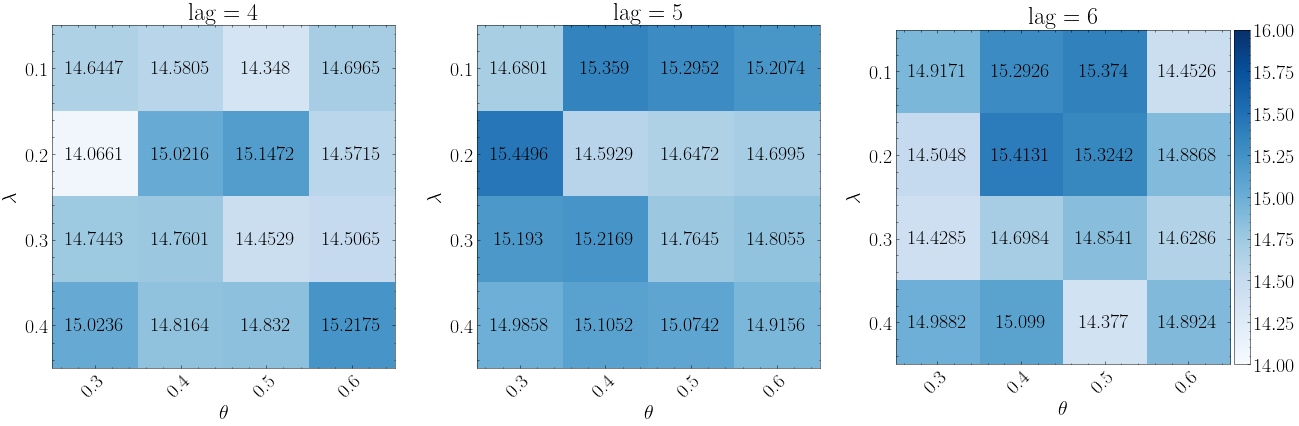

In [49]:

plt.style.use('science')
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = (20,8) 
plt.rcParams['font.size'] =  20.0
plt.rcParams['font.weight'] = 'bold'

fig, (ax0, ax1, ax2) = plt.subplots(nrows=1, ncols=3, sharex=True,   figsize=(18, 6))


lambda_ = [0.1, 0.2, 0.3, 0.4]
alpha = [0.3,0.4,0.5,0.6]

harvest0 = np.array( round(mse_set_df[mse_set_df['lag'] == 4].sort_values(['lambda','alpha'])['mean_squared_error'] ,4)).reshape(4,4)
im = ax0.imshow(harvest0, cmap='Blues', vmin=14, vmax=16)
# Show all ticks and label them with the respective list entries
ax0.set_xticks(np.arange(len(alpha)), labels=alpha)
ax0.set_yticks(np.arange(len(lambda_)), labels=lambda_)
ax0.set_xlabel(r'$\theta$')
ax0.set_ylabel(r'$\lambda$')

# Rotate the tick labels and set their alignment.
plt.setp(ax0.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
         
for i in range(len(alpha)):
    for j in range(len(lambda_)):
        text = ax0.text(j, i, harvest0[i, j],
                       ha="center", va="center", color='k') 
ax0.set_title("lag = 4")

harvest1 = np.array( round(mse_set_df[mse_set_df['lag'] == 5].sort_values(['lambda','alpha'])['mean_squared_error'] ,4)).reshape(4,4)
im = ax1.imshow(harvest1, cmap='Blues', vmin=14, vmax=16 )
# Show all ticks and label them with the respective list entries
ax1.set_xticks(np.arange(len(alpha)), labels=alpha)
ax1.set_yticks(np.arange(len(lambda_)), labels=lambda_)
ax1.set_xlabel(r'$\theta$')
ax1.set_ylabel(r'$\lambda$')

# Rotate the tick labels and set their alignment.
plt.setp(ax1.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
         
for i in range(len(alpha)):
    for j in range(len(lambda_)):
        text = ax1.text(j, i, harvest1[i, j],
                       ha="center", va="center", color='k') 
ax1.set_title("lag = 5")

harvest2 = np.array( round(mse_set_df[mse_set_df['lag'] == 6].sort_values(['lambda','alpha'])['mean_squared_error'] ,4)).reshape(4,4)
im = ax2.imshow(harvest2, cmap='Blues', vmin=14, vmax=16 )
# Show all ticks and label them with the respective list entries
ax2.set_xticks(np.arange(len(alpha)), labels=alpha)
ax2.set_yticks(np.arange(len(lambda_)), labels=lambda_)
ax2.set_xlabel(r'$\theta$')
ax2.set_ylabel(r'$\lambda$')

# Rotate the tick labels and set their alignment.
plt.setp(ax2.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
         
for i in range(len(alpha)):
    for j in range(len(lambda_)):
        text = ax2.text(j, i, harvest2[i, j],
                       ha="center", va="center", color='k') 
ax2.set_title("lag = 6")



fig.tight_layout()



divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)
plt.show()

In [118]:
rdf = pandas2ri.py2rpy(GDP_YOY_SECTORS)
globalenv['rdf'] = rdf
rscript = """
bv_priors <- bv_mn( 
lambda = bv_lambda(mode = 0.2 ),
alpha = bv_alpha(mode = 0.3 ), 
var = 10000000, 
b = 1
) 
x <- bvar(rdf, lags = 4, n_draw = 1000L, n_burn = 200L, priors = bv_priors(), verbose = FALSE)
predict(x) <- predict(x, horizon = 8)
irf(x) <- irf(x, horizon = 8, fevd = FALSE)
summary(x)
"""
result = r(rscript)
gdp_yoy_sectors_pred_lag = result[0][10][0]


In [115]:
GDP_YOY_SECTORS.index = pd.to_datetime(GDP_YOY_SECTORS.index)
GDP_YOY_SECTORS.index = GDP_YOY_SECTORS.index + pd.offsets.MonthEnd(0)
GDP_YOY_SECTORS

,AR,ID,CO,WH,TR,AC,FI,RE,OT
QTR,,,,,,,,,
1992-03-31,8.9,18.3,18.1,11.7,7.8,24.2,4.0,18.7,8.000000
1992-06-30,6.1,20.0,20.6,10.2,9.4,25.5,5.9,21.6,12.700000
1992-09-30,3.4,21.0,22.1,11.8,16.0,29.6,8.2,27.9,14.400000
1992-12-31,3.5,24.8,21.6,8.8,8.3,28.5,7.8,34.7,11.800000
1993-03-31,5.0,20.8,22.9,9.5,10.7,11.0,10.1,17.4,13.600000
...,...,...,...,...,...,...,...,...,...
2021-12-31,6.4,3.8,-2.1,5.9,4.0,4.7,5.5,-2.9,6.085922
2022-03-31,6.1,6.4,1.4,3.9,2.1,-0.3,5.1,-2.0,5.928831
2022-06-30,4.5,0.4,3.6,-1.8,-3.5,-5.3,5.9,-7.0,0.814498


In [119]:
sectors_dict = {'AR': 'Agriculture, Forestry and Fisheries', 'ID': 'Industrial', 'CO': 'Construction', 'WH': 'Wholesale and Retail',\
    'TR': 'Transportation, Storage and Postal Services', 'AC': 'Accommodation and catering', 'FI': 'Finance', 'RE': 'Real Estate',\
        'OT': 'Other Industries' }

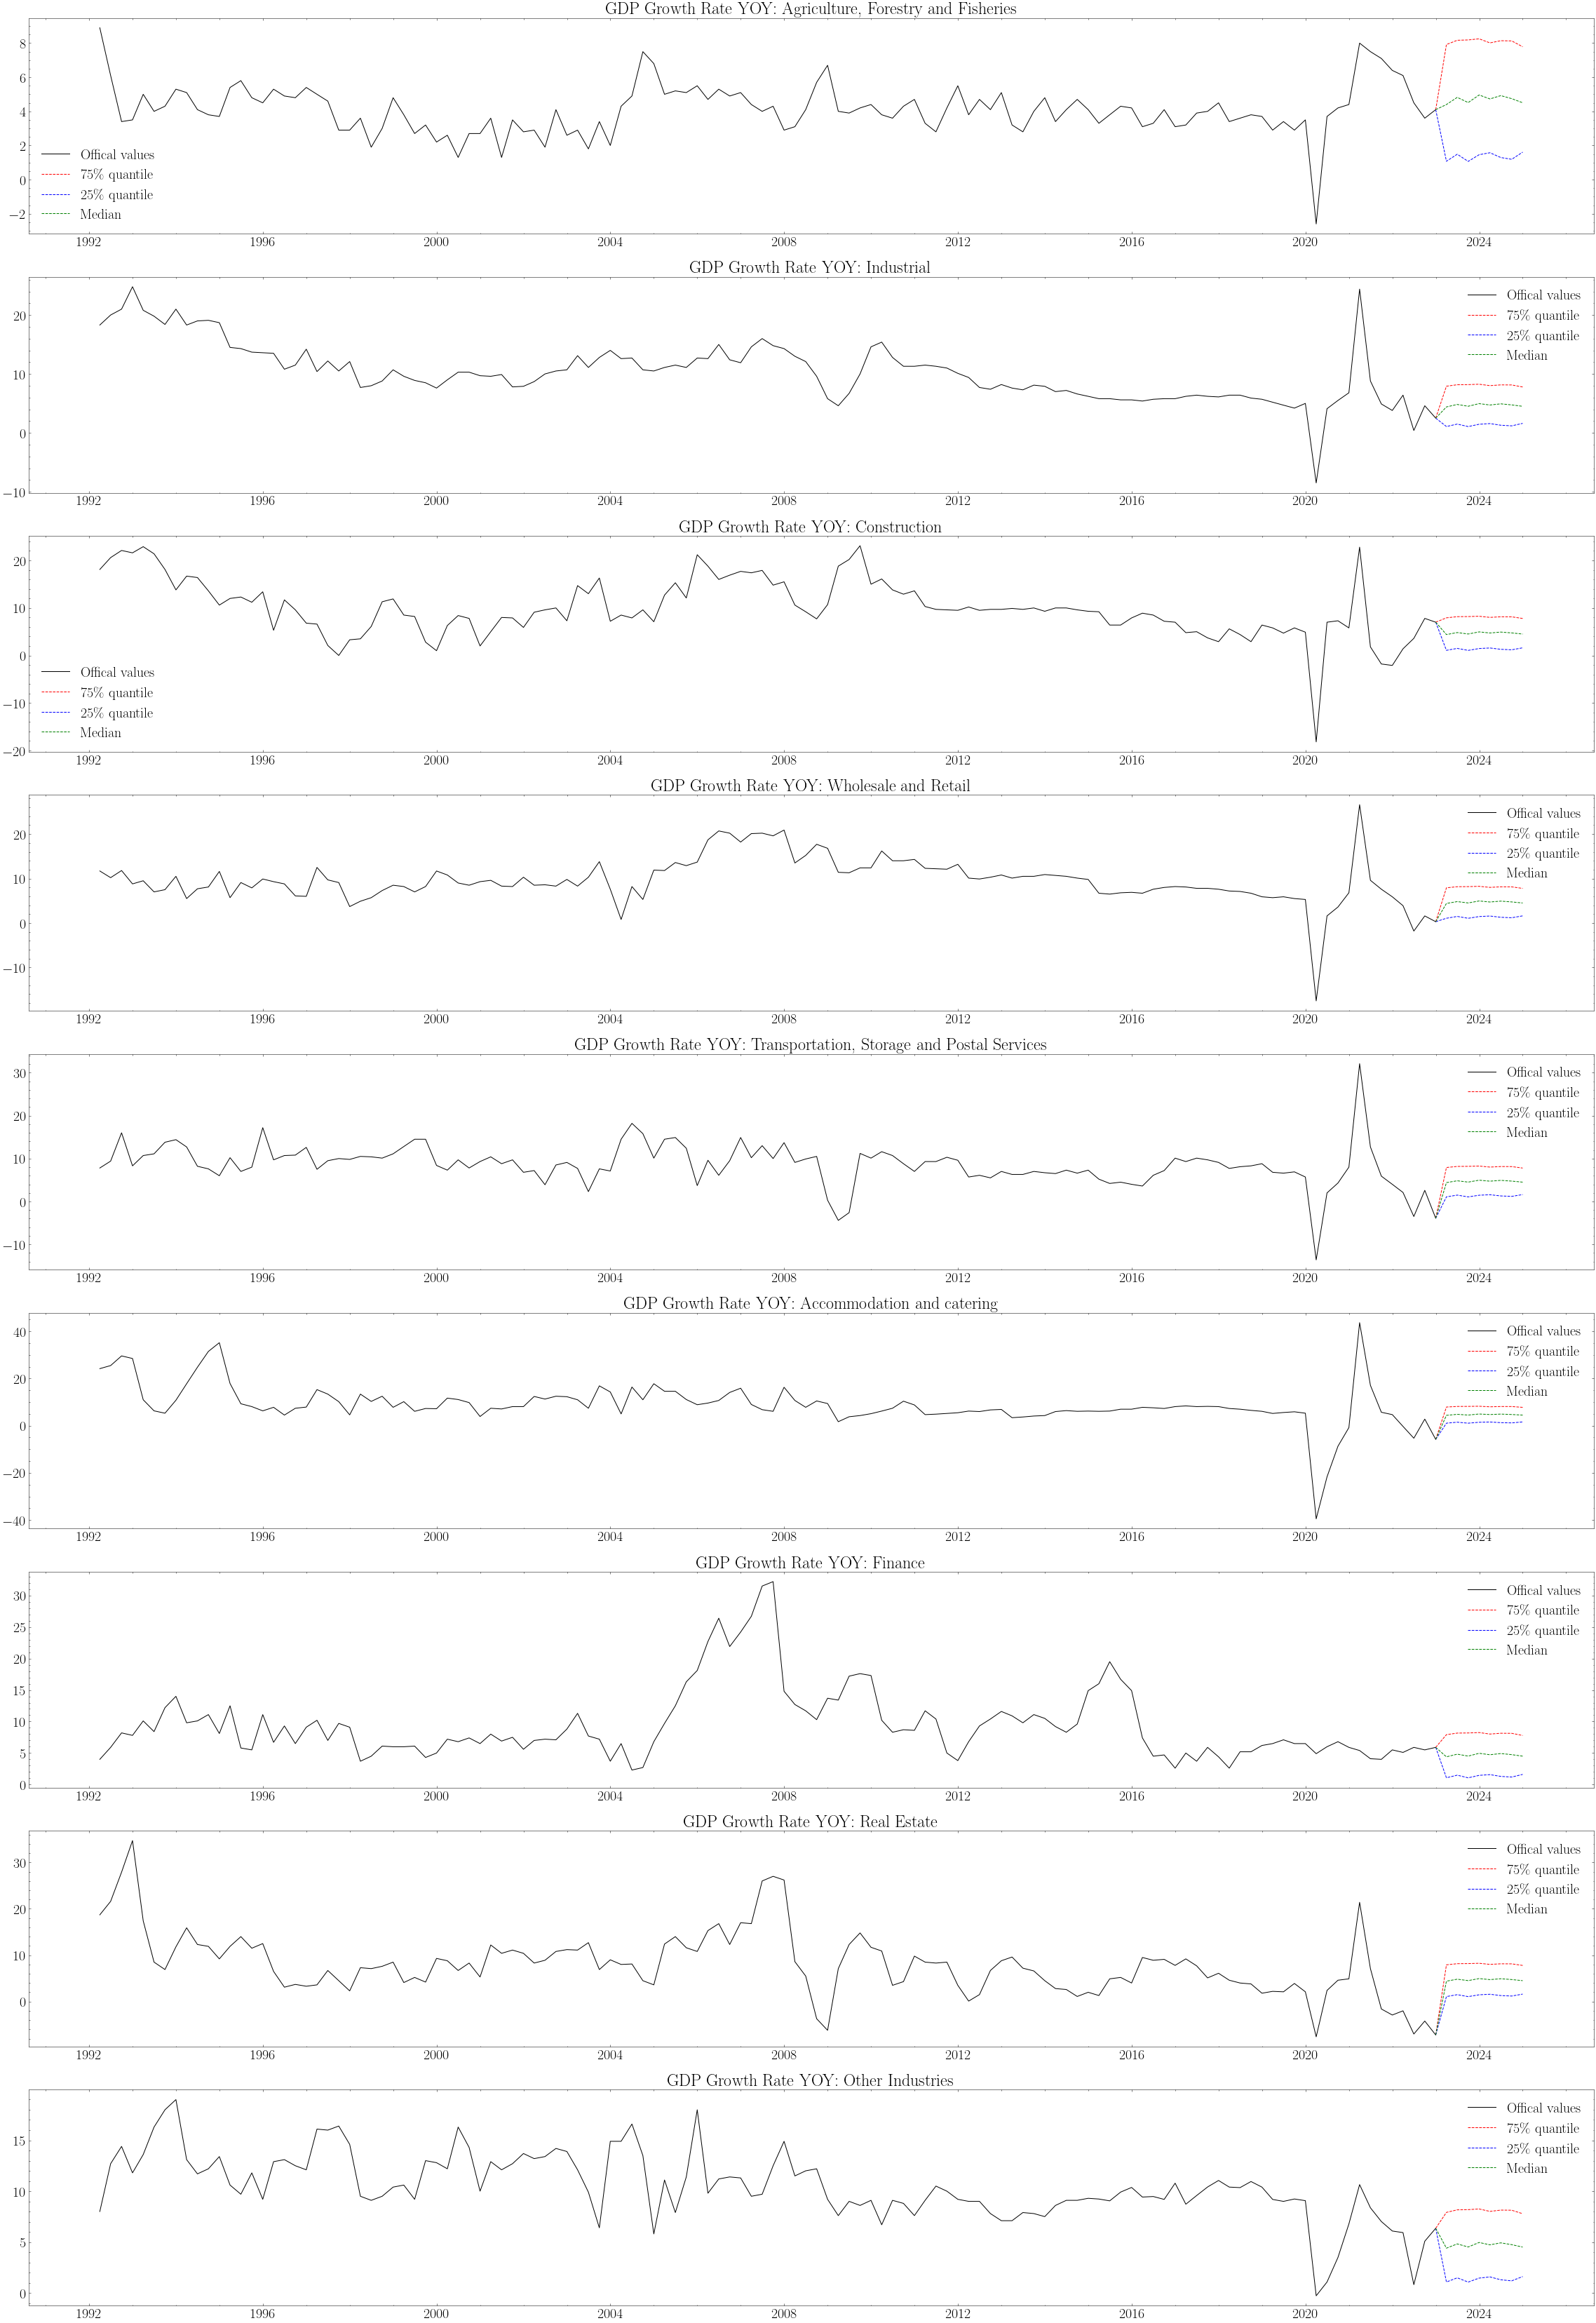

In [122]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
from mpl_toolkits.axes_grid1 import make_axes_locatable


plt.style.use('science')
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = (20,8) 
plt.rcParams['font.size'] =  20.0
plt.rcParams['font.weight'] = 'bold'

 
fig, ax = plt.subplots(nrows=len(sectors_dict), figsize=(40, 60))
for i, count in zip(sectors_dict,range(9)):
    ax[count].plot(GDP_YOY_SECTORS.index, GDP_YOY_SECTORS[i], 'k-', label = 'Offical values')
    ax[count].plot([(GDP_YOY_SECTORS.index[-1]  + pd.offsets.QuarterEnd(j)) for j in range(9)], np.insert(np.percentile(gdp_yoy_sectors_pred_lag, 75, axis = 0)[:,0], 0, GDP_YOY_SECTORS[i].iloc[-1]),  'r--', label = '75\% quantile')
    ax[count].plot([(GDP_YOY_SECTORS.index[-1]  + pd.offsets.QuarterEnd(j)) for j in range(9)], np.insert(np.percentile(gdp_yoy_sectors_pred_lag, 25, axis = 0)[:,0], 0, GDP_YOY_SECTORS[i].iloc[-1]), 'b--', label = '25\% quantile')
    ax[count].plot([(GDP_YOY_SECTORS.index[-1]  + pd.offsets.QuarterEnd(j)) for j in range(9)], np.insert(np.median(gdp_yoy_sectors_pred_lag, axis = 0)[:,0], 0, GDP_YOY_SECTORS[i].iloc[-1]),  'g--', label = 'Median')
    ax[count].set_title('GDP Growth Rate YOY: ' + sectors_dict[i])
    ax[count].legend()

plt.show()

array([<AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>,
       <AxesSubplot:>, <AxesSubplot:>, <AxesSubplot:>], dtype=object)

In [37]:
upper_pred_list = [[GDP_YOY_SECTORS.index[-1], ]]


GDP_YOY_SECTORS.index[-1]
GDP_YOY_SECTORS.index[-1] + pd.offsets.QuarterEnd(1)
GDP_YOY_SECTORS.index[-1] + pd.offsets.QuarterEnd(2)
GDP_YOY_SECTORS.index[-1] + pd.offsets.QuarterEnd(3)
GDP_YOY_SECTORS.index[-1] + pd.offsets.QuarterEnd(4)

Timestamp('2023-12-31 00:00:00')